# 2


In [21]:
from load_datasets import (
    train_val_generator,
    val_generator,
    train_generator,
    X_train,
    X_val,
    X_test,
    y_test
)
from helper_functions import flatten_list
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import pandas as pd

In [22]:
def create_Conv2D_MaxPooling2D_pairs(kernel_number):
    return [
        Conv2D(
            kernel_number,
            padding="same",
            kernel_size=(3, 3),
            activation="relu",
            kernel_initializer="he_normal",
            input_shape=(32, 32, 3),
        ),
        MaxPooling2D(pool_size=(2, 2), strides=2),
    ]

X_train.shape[1:]  # Input shape

(32, 32, 3)

In [23]:
def create_Dense_Dropout_pairs(node_dropout_pair):
    return [
        Dense(node_dropout_pair[0], activation="relu", kernel_initializer="he_normal"),
        Dropout(node_dropout_pair[1]),
    ]

In [24]:
def model_cnn_2_classes(
    cnn_kernel_numbers: list,
    mlp_node_dropout_pairs,
    *,
    name: str = "cnn_model_2_classes",
    optimizer=Adam(learning_rate=0.001),
    metrics=["acc"],
    flatten_layer_dropout_rate=.3
):
    flatten_layer=[Flatten(), Dropout(flatten_layer_dropout_rate)]
    model = Sequential(
        flatten_list(
            [
                create_Conv2D_MaxPooling2D_pairs(kernel_number)
                for kernel_number in cnn_kernel_numbers
            ]
        )
        + flatten_layer
        + flatten_list(
            [
                create_Dense_Dropout_pairs(node_dropout_pair)
                for node_dropout_pair in mlp_node_dropout_pairs
            ]
        )
        + [Dense(1, activation="sigmoid", name="output_layer")],
        name=name,
    )
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics)
    return model

In [25]:
def plot_and_print_model_metrics(metrics:pd.DataFrame):
    _, ax = plt.subplots(1, 2, figsize=(12, 4))
    print(f'val_acc: {metrics["val_acc"].sort_values().iloc[-1]}')
    metrics[["loss", "val_loss"]].plot(ax=ax[0], grid=True)
    metrics[["acc", "val_acc"]].plot(ax=ax[1], grid=True)

In [26]:
int(len(X_train) / 32), int(len(X_val) / 32)

(50, 12)

In [49]:
def fit_then_evaluate_model(
    model,
    *,
    steps_per_epoch=50,
    validation_steps=12,
    model_fit_verbosity=0,
    print_model_summary=False
):
    if print_model_summary:
        return print(model.summary())
    early_stopper = EarlyStopping(
        monitor="val_acc", mode="max", patience=50, restore_best_weights=True
    )
    model.fit(
        train_val_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=100000,
        callbacks=[early_stopper],
        validation_data=val_generator,
        validation_steps=validation_steps,
        verbose=model_fit_verbosity,
    )
    metrics = pd.DataFrame(model.history.history)
    plot_and_print_model_metrics(metrics)

    return model

val_acc: 0.7421875
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_107 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_107 (MaxPooli  (None, 16, 16, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_108 (Conv2D)         (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_108 (MaxPooli  (None, 8, 8, 64)         0         
 ng2D)                                                           
                                                                 
 conv2d_109 (Conv2D)         (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_109 (MaxPooli  (None, 4, 

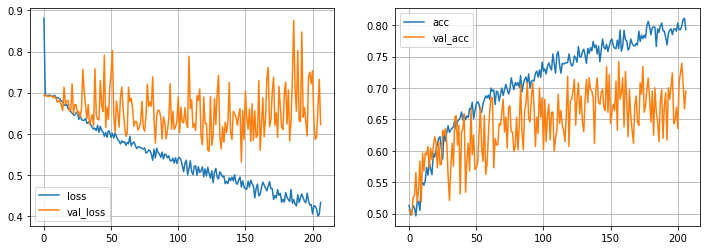

In [50]:
model_1__kernel_numbers = [32, 64, 128, 128]
model_1__node_dropout_pairs = [(512, 0)]
model_1 = model_cnn_2_classes(model_1__kernel_numbers, model_1__node_dropout_pairs, name="model_1")
fit_then_evaluate_model(model_1, print_model_summary=True);

## b)


### Tuning components

val_acc: 0.71875
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_123 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_123 (MaxPooli  (None, 16, 16, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_124 (Conv2D)         (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_124 (MaxPooli  (None, 8, 8, 64)         0         
 ng2D)                                                           
                                                                 
 conv2d_125 (Conv2D)         (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_125 (MaxPooli  (None, 4, 4,

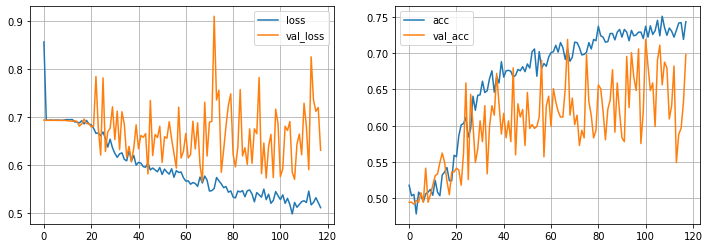

In [54]:
model_2__kernel_numbers = [32, 64, 128, 256]
model_1__node_dropout_pairs = [(256, .5)]
model_2 = model_cnn_2_classes(model_2__kernel_numbers, model_1__node_dropout_pairs, name='model_2', flatten_layer_dropout_rate=.5)
fit_then_evaluate_model(model_2, print_model_summary=True);

## Selecting model

In [ ]:
cat_dog_32x32_image_model = model_cnn_2_classes(model_X__kernel_numbers, model_X__node_dropout_pairs, name='cat_dog_classifier', flatten_layer_dropout_rate=.2)
# cat_dog_32x32_image_model.fit(
#         train_generator,
#         steps_per_epoch=50,
#         epochs=100,
#         verbose=1
#     )

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = cat_dog_32x32_image_model.predict(X_test)
y_pred = (y_pred > .5) * 1

# print(classification_report(y_test, y_pred))
# cm = confusion_matrix(y_test, y_pred)
# ConfusionMatrixDisplay(cm).plot();